# Progetto Foundation of Deep Learning
Gaetano Chiriaco (882638) - Gianmarco Russo (887277)

## Import e setup

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img,save_img

from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import cv2
import splitfolders


from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

import pandas as pd
import time
from PIL import Image
from tqdm import tqdm

from keras import backend as K

In [ ]:
import imageio
images = []
i=0
for filename in os.listdir('/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_masked_gan/normal'):
    i+=1
    if i > 299:
      images.append(imageio.imread('/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_masked_gan/normal'+"/"+filename))
imageio.mimsave('/content/gdrive/MyDrive/Progetto-FDL/Presentation/masked_normal_gan.gif', images)

Definizione delle metriche necessarie per la valutazione di classificazioni nel caso di problemi sbilanciati

In [ ]:
# Recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1-Measure
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Class Accuracy
def class_accuracy(model,val,class_labels=["chip","dirt","normal"]):
    real_labels = np.array([])
    pred_labels = np.array([])
    for i in val:
      xi,yi = i
      pi = model.predict_on_batch(xi)
      real_labels = np.append(real_labels,[np.where(yi==1)[1]])
      pred_labels = np.append(pred_labels,[np.argmax(pi,axis=1)])
  
    class_acc = dict()
    for c in np.unique(real_labels):
      class_acc[class_labels[int(c)]]=sum(pred_labels[real_labels==c] ==c)/len(pred_labels[real_labels==c])
  
    return class_acc

Collegamento alla cartella drive contentente la cartella images del file pillQC-main.zip

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Preparazione e trasformazione *dataset*

### Trasformazione in Grayscale e masking

Funzione per il masking e la trasformazione in grayscale

In [ ]:
def mask_image(image_path,mask_path,source_image_name,gray_path="",gray= True,min_var=81):
  # Lettura dell'immagine da trasformare
  source_image = cv2.imread(image_path)

  # Trasformazione in grayscale
  grayscale_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)

  # Salvataggio dell'immagine grayscale nel path scelto (gray_path)
  if gray:
    cv2.imwrite(gray_path+"/"+source_image_name, grayscale_image)
  
  # Correzione del noise
  denoised_image = cv2.GaussianBlur(grayscale_image,(3,3),0)

  # Identificazione dei margini
  edges = cv2.Canny(denoised_image, 100, 130)

  # Correzione dei margini
  kernel = np.ones((1,1), np.uint8)
  eroded_edges = cv2.erode(edges, kernel, iterations = 10)
  kernel = np.ones((2,2), np.uint8)
  dilated_edges = cv2.dilate(eroded_edges, kernel, iterations = 1)


  dilated_edges_copy = dilated_edges.copy()
  ret, thresh = cv2.threshold(dilated_edges_copy, 20, 255, 0)

  # Selezione dei margini e identificazione delle gerarchie
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  hierarchy_parents_only = [x[3] for x in hierarchy[0]]

  selected_contour = list()
  selected_hierarchy = list()
  max_area = -1

  # Selezione dei contorni chiusi con area maggiore e non inclusi in altri
  for index,contour in enumerate(contours):
    if hierarchy_parents_only[index] == -1:
      area = cv2.contourArea(contour)
      if area > max_area:
        if len(selected_contour)==0:
          selected_contour.append(contour)
          selected_hierarchy.append(hierarchy[0][index])
        else:
          selected_contour[0]=contour
          selected_hierarchy[0]=hierarchy[0][index]
        max_area=area

  # Identificazione del centro del contorno e del suo lato più lungo
  max_diff_x = -1
  max_diff_y = -1
  mid_point_x = -1
  mid_point_y = -1

  for i in range(selected_contour[0].shape[0]):
    for j in range(selected_contour[0].shape[0]):
      diff_x = abs(selected_contour[0][i,0,0] - selected_contour[0][j,0,0])
      if diff_x >max_diff_x:
        max_diff_x = diff_x
        mid_point_x = (selected_contour[0][i,0,0] + selected_contour[0][j,0,0])/2
        mid_point_y = (selected_contour[0][i,0,1] + selected_contour[0][j,0,1])/2

  # Definizione del cerchio da utilizzare per tagliare l'immagine
  mask = np.zeros_like(denoised_image)
  mask = cv2.circle(mask, (int(mid_point_x),int(mid_point_y)), int(max_diff_x/2), (1,1,1), -1)
  image_01 = denoised_image/255
  circled= (image_01*mask)*255
  var_image = round(circled.var()/int(max_diff_x/2),2)
  
  # Se l'immagine non è tagliata sufficientemente bene non viene salvata
  if var_image>min_var:
    cv2.imwrite(mask_path+"/"+source_image_name, circled)
  
  return var_image


In [ ]:
# Definizione dei path in cui salvare le immagini
data_path='/content/gdrive/MyDrive/Progetto-FDL/Datasets/images/'
masked_path='/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_masked/'
gray_path = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_gray/'

# Creazione della cartella per le immagini "masked" se non esiste
if not os.path.exists(masked_path):
    os.makedirs(masked_path)

# Creazione della cartella per le immagini "gray" se non esiste
if not os.path.exists(gray_path):
    os.makedirs(gray_path)


# Per ogni immagine originale
for c in os.listdir(data_path):
  try:

    # Creazione delle cartelle per salvare le immagini di ogni classe
    if not os.path.exists(masked_path+c):
      os.makedirs(masked_path+c)
    if not os.path.exists(gray_path+c):
      os.makedirs(gray_path+c)

    # Per ogni immagine originale viene applicato il grayscale ed il masking  
    for i in os.listdir(data_path+c):
      try:
        path_image = data_path+c+"/"+i
        if path_image.endswith(".jpg"):
          variance= mask_image(path_image,masked_path+c,i,gray_path+c)
          
          print(i,"var:",variance)
      except BaseException as e:
        print(i,":",e)
        
  except BaseException as e:
    print(e)


chip0037.jpg var: 93.6
chip0041.jpg var: 96.22
chip0026.jpg var: 99.93
chip0003.jpg var: 78.04
chip0004.jpg var: 83.36
chip0034.jpg var: 93.46
chip0020.jpg var: 76.27
chip0027.jpg var: 77.53
chip0024.jpg var: 96.23
chip0007.jpg var: 90.54
chip0019.jpg var: 102.69
chip0040.jpg var: 75.45
chip0033.jpg var: 83.46
chip0030.jpg var: 93.99
chip0006.jpg var: 89.46
chip0022.jpg var: 80.92
chip0002.jpg var: 105.61
chip0032.jpg var: 76.92
chip0043.jpg var: 101.43
chip0042.jpg var: 93.68
chip0031.jpg var: 93.57
chip0008.jpg var: 103.06
chip0005.jpg var: 102.05
chip0035.jpg var: 93.18
chip0029.jpg var: 88.46
chip0028.jpg var: 107.12
chip0039.jpg var: 60.58
chip0011.jpg var: 104.29
chip0001.jpg var: 95.53
chip0016.jpg var: 95.16
chip0036.jpg var: 104.13
chip0017.jpg var: 87.85
chip0015.jpg var: 96.73
chip0038.jpg var: 97.8
chip0025.jpg var: 104.44
chip0023.jpg var: 100.44
chip0012.jpg var: 94.7
chip0018.jpg var: 105.36
chip0009.jpg var: 108.88
chip0014.jpg var: 96.99
chip0013.jpg var: 92.53
chip001

### Load di Train/Val/Test set

Impostazione path delle immagini e path dove andremo a mettere le immagini campionate in modo stratificato

In [ ]:
# Path per le immagini normali
base_path = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/images'
base_split_path  = "/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split"

# Path per le immagini in grayscale
gray_path = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_gray'
gray_split_path  = "/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split_gray"

# Path per le immagini masked
mask_path = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_masked'
mask_split_path  = "/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split_masked"

Utilizzo della libreria splitfolder per la ripartizione delle immagini



1.   60% train
2.   20% validation
3.   20% test



Splitting delle immagini in train/test/validation in modo stratificato

In [ ]:
# Splitting delle immagini RGB
splitfolders.ratio(base_path, output=base_split_path, seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)
# Splitting delle immagini Grayscale
splitfolders.ratio(gray_path, output=gray_split_path, seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)
# Splitting delle immagini Masked
splitfolders.ratio(mask_path, output=mask_split_path, seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)

Copying files: 330 files [00:03, 96.75 files/s] 
Copying files: 330 files [00:03, 88.87 files/s] 
Copying files: 291 files [00:03, 91.08 files/s]


Visualizziamo le proporzioni di ripartizione:

In [ ]:
print("Test")
img_test = len(os.listdir(base_split_path+"/"+"test"+"/"+"chip")) + len(os.listdir(base_split_path+"/"+"test"+"/"+"dirt")) + len(os.listdir(base_split_path+"/"+"test"+"/"+"normal"))
print(len(os.listdir(base_split_path+"/"+"test"+"/"+"chip"))/img_test*100)
print(len(os.listdir(base_split_path+"/"+"test"+"/"+"dirt"))/img_test*100)
print(len(os.listdir(base_split_path+"/"+"test"+"/"+"normal"))/img_test*100)
print("Val")
img_val = len(os.listdir(base_split_path+"/"+"val"+"/"+"chip")) + len(os.listdir(base_split_path+"/"+"val"+"/"+"dirt")) + len(os.listdir(base_split_path+"/"+"val"+"/"+"normal"))
print(len(os.listdir(base_split_path+"/"+"val"+"/"+"chip"))/img_val*100)
print(len(os.listdir(base_split_path+"/"+"val"+"/"+"dirt"))/img_val*100)
print(len(os.listdir(base_split_path+"/"+"val"+"/"+"normal"))/img_val*100)
print("Train")
img_val = len(os.listdir(base_split_path+"/"+"train"+"/"+"chip")) + len(os.listdir(base_split_path+"/"+"train"+"/"+"dirt")) + len(os.listdir(base_split_path+"/"+"train"+"/"+"normal"))
print(len(os.listdir(base_split_path+"/"+"train"+"/"+"chip"))/img_val*100)
print(len(os.listdir(base_split_path+"/"+"train"+"/"+"dirt"))/img_val*100)
print(len(os.listdir(base_split_path+"/"+"train"+"/"+"normal"))/img_val*100)

Test
14.285714285714285
41.42857142857143
44.285714285714285
Val
12.5
42.1875
45.3125
Train
12.755102040816327
41.83673469387755
45.40816326530612


### Data Augmentation

In [ ]:
# Normal path augmentation
base_train_path = base_split_path+"/train"
base_train_aug_path  = base_train_path+"_aug"
# gray path augmentation
gray_train_path = gray_split_path+"/train"
gray_train_aug_path  = gray_train_path+"_aug"
# masked path augmentation
mask_train_path = mask_split_path+"/train"
mask_train_aug_path  = mask_train_path+"_aug"

Funzione per applicare Data Augmentation standard

Trasformazioni casuali applicate:


*   Rotation
*   Horizontal flip
*   Vertical flip







In [ ]:
def std_aug(train_path, aug_path,n_aug=2):
  # Creazione della cartella in cui salvare le immagini originali ed augmented
  if not os.path.isdir(aug_path):
    os.mkdir(aug_path)

  # Funzione per l'augmentation
  datagen = ImageDataGenerator(rotation_range=360,horizontal_flip=True, vertical_flip=True)

  # Lettura di ogni immagine nel train set originale e augmentation 
  for c in os.listdir(train_path):
    if not os.path.isdir(aug_path+"/"+c):
      os.mkdir(aug_path+"/"+c)
    for i in os.listdir(train_path+"/"+c):
      img = load_img(train_path + "/" + c + "/" + i) 
      save_img(aug_path + "/" + c + "/" + i,img) 
      x = img_to_array(img) 
      j = 0
      x = x.reshape((1, ) + x.shape) 
      # Creazione di n_aug immagini augmented per ogni immagine originale 
      for batch in datagen.flow(x, batch_size = 1, 
                        save_to_dir = aug_path+"/"+c,
                        save_format ='jpg'):
          j += 1
          if j >= n_aug: 
              break


In [ ]:
# Augmentation delle immagini originali 
std_aug(base_train_path, base_train_aug_path)

# Augmentation delle immagini grayscale
std_aug(gray_train_path, gray_train_aug_path)

# Augmentation delle immagini 
std_aug(mask_train_path, mask_train_aug_path)

Data Loading:
Carichiamo le porzioni di dataset in train, train augmented, validation e test. Creiamo una funzione che riceva in input il path e il color channel e si occupi di ciò.

In [ ]:
def data_loader(path,color_mode="rgb"):

  # Load del train set
  train_dataset = keras.preprocessing.image_dataset_from_directory(path+"/train",
                                                            labels="inferred",
                                                            image_size=(224,224),
                                                            color_mode=color_mode,
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)
  
  # Load del train augmented set
  train_aug_dataset = keras.preprocessing.image_dataset_from_directory(path+"/train_aug",
                                                            labels="inferred",
                                                            image_size=(224,224),
                                                            color_mode=color_mode,
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)
  
  # Load del validation set
  val_dataset = keras.preprocessing.image_dataset_from_directory(path+"/val",
                                                            labels="inferred",
                                                            image_size=(224,224),
                                                            color_mode=color_mode,
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)
  
  # Load del test set
  test_dataset = keras.preprocessing.image_dataset_from_directory(path+"/test",
                                                            labels="inferred",
                                                            image_size=(224,224),
                                                            color_mode=color_mode,
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)
  return train_dataset, train_aug_dataset, val_dataset, test_dataset

In [ ]:
# Caricamento del train/train augmented/validation/test set per ogni tipologia di immagine utilizzata

train_b, aug_b, val_b,test_b = data_loader(base_split_path,color_mode="rgb")

train_g, aug_g, val_g,test_g = data_loader(gray_split_path,color_mode="grayscale")

train_m, aug_m, val_m,test_m = data_loader(mask_split_path,color_mode="grayscale")

Found 196 files belonging to 3 classes.
Found 781 files belonging to 3 classes.
Found 64 files belonging to 3 classes.
Found 70 files belonging to 3 classes.
Found 196 files belonging to 3 classes.
Found 777 files belonging to 3 classes.
Found 64 files belonging to 3 classes.
Found 70 files belonging to 3 classes.
Found 173 files belonging to 3 classes.
Found 781 files belonging to 3 classes.
Found 57 files belonging to 3 classes.
Found 61 files belonging to 3 classes.


In [ ]:
# Nomi delle classi
class_names = train_b.class_names
print(class_names)

['chip', 'dirt', 'normal']


Visualizzazione delle immagini e le label ad esse associate 

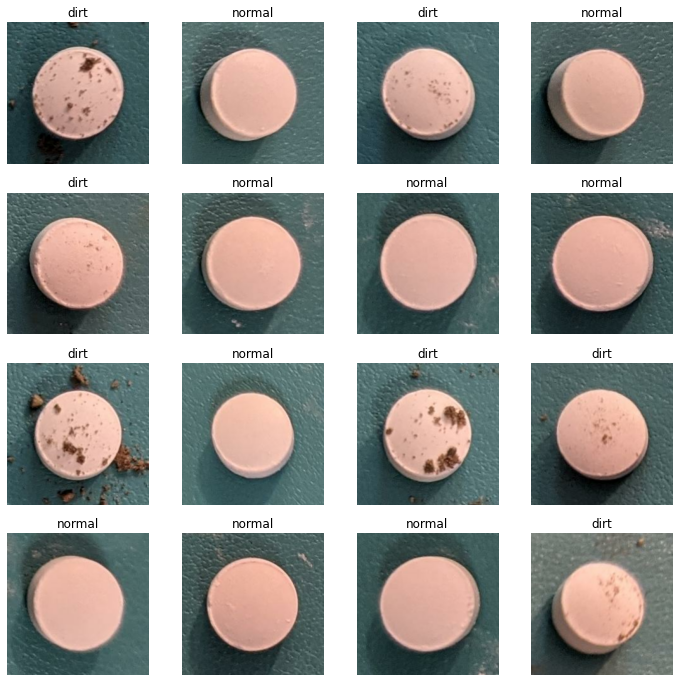

In [ ]:
# Normal images
plt.figure(figsize=(12,12))
for images, labels in train_b.take(1):
  label_name= tf.where(labels==1)
  for i in range(16):
      ax=plt.subplot(4,4, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[label_name[i][1]])
      plt.axis("off")

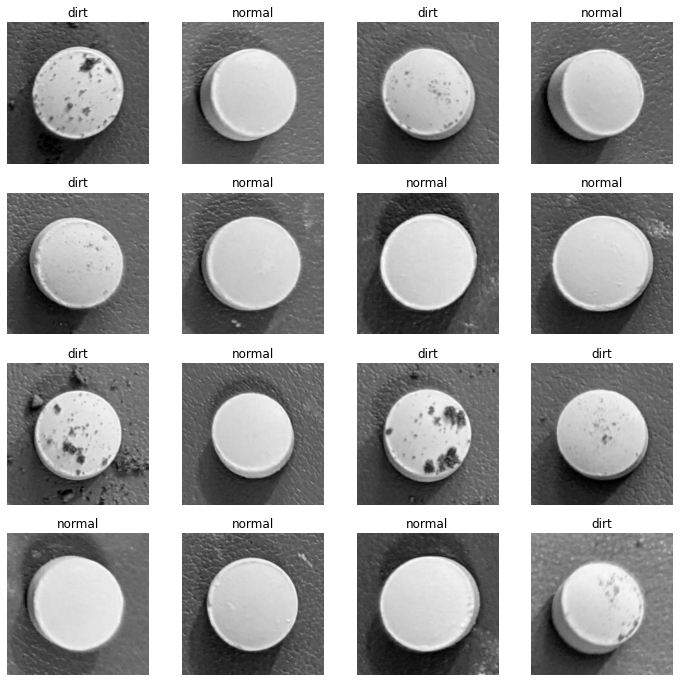

In [ ]:
# Grayscale
plt.figure(figsize=(12,12))
for images, labels in train_g.take(1):
  label_name= tf.where(labels==1)
  for i in range(16):
      ax=plt.subplot(4,4, i+1)
      plt.imshow(images[i][:,:,0].numpy().astype("uint8"),cmap="gray")
      plt.title(class_names[label_name[i][1]])
      plt.axis("off")


## Classificazione

### Definizione architettura CNN

Definiamo una funzione che inizializzi la rete:

In [ ]:
def build_net(channel):
  
  model = Sequential()
  #layer convoluzionale con kernel size 3x3, definiamo anche le dimensioni dell'immagine
  model.add(Conv2D(32, kernel_size=3, input_shape=(224,224,channel), 
                      padding="same"))
  #leakyrelu come funzione di attivazione in quanto limita l'annullamento del gradiente
  model.add(LeakyReLU(alpha=0.2))
  #layer di maxpooling con stride 3
  model.add(MaxPooling2D(3, strides=3, padding="same"))

  #ripetiamo l'operazione incrementando i parametri della convoluzione

  model.add(Conv2D(64, kernel_size=3, padding="same"))
  #batch normalization per normalizzare i parametri tra un layer ed un altro
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(3, strides=3, padding="same"))

  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(3, strides=3, padding="same"))

  model.add(Conv2D(256, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(GlobalMaxPooling2D())

  #layer flatten che trasforma la matrice in ingresso in un vettore
  model.add(Flatten())
  #layer fully-connected per mappare l'output alle 3 classi
  model.add(Dense(3, activation='softmax'))
  return model

Modello per immagini grayscale e masked

In [ ]:
model_gray= build_net(1)
model_mask= build_net(1)

model_gray.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 75, 75, 64)        0

Modello per le immagini RGB

In [ ]:
model_rgb= build_net(3)
model_rgb.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 75, 75, 64)       

### Compiling

Impostiamo funzione di costo, callbacks,optimizer e metriche.
La funzione di costo, visto che si tratta di un problema multiclasse, sarà la categorical crossentropy. 
La funzione di ottimizzazione scelta è la Adam, con learning rate alpha=0.0001.Le metriche considerate sono accuracy, f1, precision e recall.

In [ ]:
#definizione dell'early stopping con pazienza 5 sulla loss di validation che si servirà per il training
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
# Compling dei modelli
model_rgb.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy',recall_m,precision_m,f1_m])

model_gray.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy',recall_m,precision_m,f1_m])

model_mask.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy',recall_m,precision_m,f1_m])

### Training CNN su immagini RGB

Effettuiamo il training per 50 epoche con early stopping pari a 5, ovvero se la loss non migliora dopo 5 epoche, il training si interrompe.

In [ ]:
history_rgb = model_rgb.fit(train_b,
                            epochs=50,
                            validation_data=val_b,
                            callbacks = [callback])

Epoch 1/50
7/7 [==============================] - 68s 2s/step - loss: 0.8864 - accuracy: 0.5408 - recall_m: 0.4821 - precision_m: 0.5859 - f1_m: 0.5240 - val_loss: 0.5925 - val_accuracy: 0.7969 - val_recall_m: 0.7812 - val_precision_m: 0.7933 - val_f1_m: 0.7872
Epoch 2/50
7/7 [==============================] - 1s 75ms/step - loss: 0.2744 - accuracy: 0.9388 - recall_m: 0.9196 - precision_m: 0.9667 - f1_m: 0.9421 - val_loss: 0.2686 - val_accuracy: 0.9531 - val_recall_m: 0.9219 - val_precision_m: 1.0000 - val_f1_m: 0.9593
Epoch 3/50
7/7 [==============================] - 1s 68ms/step - loss: 0.1730 - accuracy: 0.9643 - recall_m: 0.9643 - precision_m: 0.9774 - f1_m: 0.9707 - val_loss: 0.1920 - val_accuracy: 1.0000 - val_recall_m: 0.9688 - val_precision_m: 1.0000 - val_f1_m: 0.9841
Epoch 4/50
7/7 [==============================] - 1s 67ms/step - loss: 0.1232 - accuracy: 0.9745 - recall_m: 0.9777 - precision_m: 0.9821 - f1_m: 0.9799 - val_loss: 0.1497 - val_accuracy: 0.9688 - val_recall_m: 0

#### Valutazione delle performance 

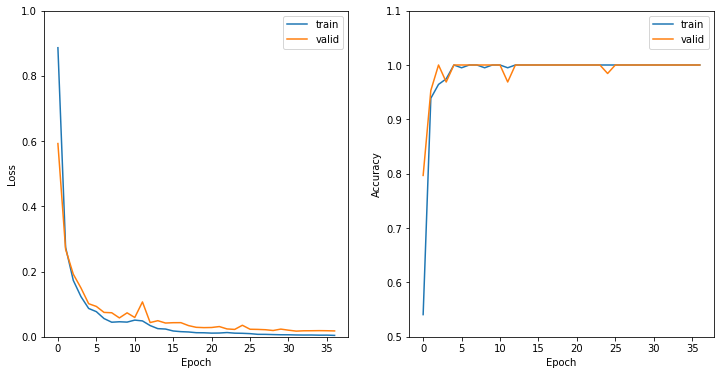

In [ ]:
# Plot della loss per le epoche
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history_rgb.history['loss'])
plt.plot(history_rgb.history['val_loss'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# Plot dell'accuratezza
plt.subplot(1, 2, 2)
plt.plot(history_rgb.history['accuracy'])
plt.plot(history_rgb.history['val_accuracy'])
plt.ylim([0.5, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.savefig("output-bargraph.pdf", transparent=True)

Notiamo come le performance siano eccellenti, il che ci mette in guardia su possibili bias del modello.

In [ ]:
model_rgb.evaluate(test_b, batch_size=16)

3/3 [==============================] - 15s 92ms/step - loss: 0.0131 - accuracy: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - f1_m: 1.0000


[0.013125715777277946, 1.0, 1.0, 1.0, 1.0]

In [ ]:
model_rgb.save('/content/gdrive/MyDrive/Progetto-FDL/model_rgb.h5')

### Training CNN su immagini GrayScale

Con la stessa rete definita poc'anzi addestriamo un modello che lavori sulle immagini grayscale e valutiamone i risultati:

In [ ]:
history_gray = model_gray.fit(train_g,
                            epochs=50,
                            validation_data=val_g,
                            callbacks=[callback])

Epoch 1/50
7/7 [==============================] - 46s 2s/step - loss: 3.1763 - accuracy: 0.2755 - recall_m: 0.2411 - precision_m: 0.2429 - f1_m: 0.2420 - val_loss: 0.8291 - val_accuracy: 0.5312 - val_recall_m: 0.5312 - val_precision_m: 0.5862 - val_f1_m: 0.5574
Epoch 2/50
7/7 [==============================] - 1s 61ms/step - loss: 0.5629 - accuracy: 0.7551 - recall_m: 0.6875 - precision_m: 0.8283 - f1_m: 0.7505 - val_loss: 0.4162 - val_accuracy: 0.8438 - val_recall_m: 0.7969 - val_precision_m: 0.8959 - val_f1_m: 0.8434
Epoch 3/50
7/7 [==============================] - 1s 58ms/step - loss: 0.3499 - accuracy: 0.8827 - recall_m: 0.8571 - precision_m: 0.9044 - f1_m: 0.8794 - val_loss: 0.3685 - val_accuracy: 0.8281 - val_recall_m: 0.7969 - val_precision_m: 0.8638 - val_f1_m: 0.8289
Epoch 4/50
7/7 [==============================] - 1s 59ms/step - loss: 0.2240 - accuracy: 0.9592 - recall_m: 0.9420 - precision_m: 0.9820 - f1_m: 0.9610 - val_loss: 0.2420 - val_accuracy: 0.9688 - val_recall_m: 0

#### Valutazione delle performance

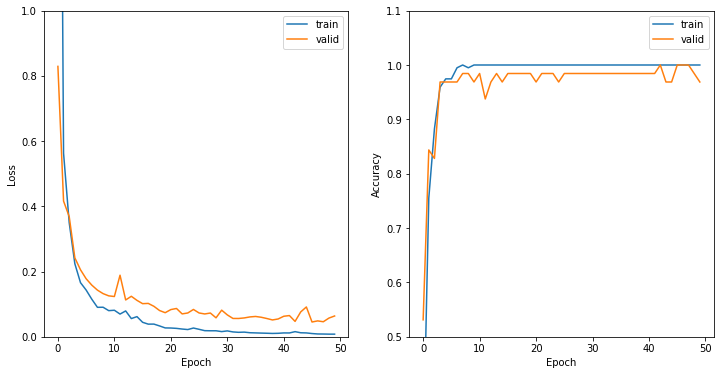

In [ ]:
# Plot della loss per le epoche
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history_gray.history['loss'])
plt.plot(history_gray.history['val_loss'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# Plot dell'accuratezza
plt.subplot(1, 2, 2)
plt.plot(history_gray.history['accuracy'])
plt.plot(history_gray.history['val_accuracy'])
plt.ylim([0.5, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.savefig("output-bargraph.pdf", transparent=True)

In [ ]:
class_accuracy(model_gray,test_g)

{'chip': 1.0, 'dirt': 0.9655172413793104, 'normal': 1.0}

In [ ]:
# Valutazione delle performance sul test set
model_gray.evaluate(test_g, batch_size=16)

3/3 [==============================] - 0s 16ms/step - loss: 0.0568 - accuracy: 0.9857 - recall_m: 0.9896 - precision_m: 0.9896 - f1_m: 0.9896


[0.056842803955078125,
 0.9857142567634583,
 0.9895833134651184,
 0.9895833134651184,
 0.9895833134651184]

In [ ]:
# Salvataggio del modello
model_gray.save('/content/gdrive/MyDrive/Progetto-FDL/model_gray.h5')

### Training CNN su immagini Masked

Eseguiamo per una terza volta la stessa operazione con le immagini masked:

In [ ]:
history_mask = model_mask.fit(train_m,
                            epochs=50,
                            validation_data=val_m,
                            callbacks=[callback])

Epoch 1/50
6/6 [==============================] - 47s 4s/step - loss: 1.4274 - accuracy: 0.3815 - recall_m: 0.3450 - precision_m: 0.4382 - f1_m: 0.3831 - val_loss: 1.0618 - val_accuracy: 0.5088 - val_recall_m: 0.4969 - val_precision_m: 0.5167 - val_f1_m: 0.5065
Epoch 2/50
6/6 [==============================] - 11s 2s/step - loss: 0.8938 - accuracy: 0.6936 - recall_m: 0.6779 - precision_m: 0.7345 - f1_m: 0.7036 - val_loss: 0.8250 - val_accuracy: 0.6842 - val_recall_m: 0.6481 - val_precision_m: 0.7257 - val_f1_m: 0.6847
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.6348 - accuracy: 0.7457 - recall_m: 0.6987 - precision_m: 0.8169 - f1_m: 0.7515 - val_loss: 0.6911 - val_accuracy: 0.7193 - val_recall_m: 0.6794 - val_precision_m: 0.7917 - val_f1_m: 0.7312
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 0.4893 - accuracy: 0.9075 - recall_m: 0.7608 - precision_m: 0.9464 - f1_m: 0.8431 - val_loss: 0.6441 - val_accuracy: 0.7368 - val_recall_m: 0.69

#### Valutazione delle performance

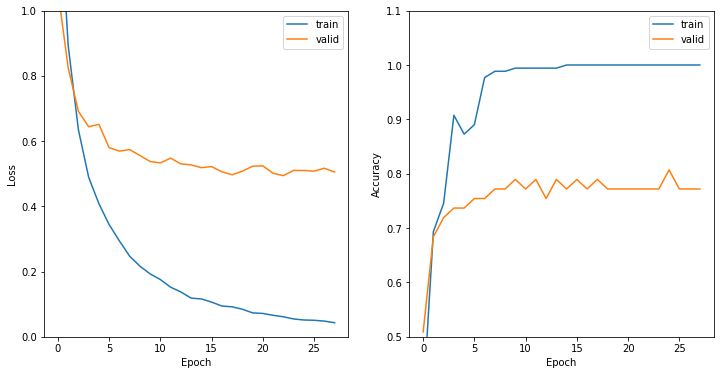

In [ ]:
# Plot dei valori della funzione di loss per le varie epoche
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history_mask.history['loss'])
plt.plot(history_mask.history['val_loss'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# Plot dell'accuratezza per le varie epoche
plt.subplot(1, 2, 2)
plt.plot(history_mask.history['accuracy'])
plt.plot(history_mask.history['val_accuracy'])
plt.ylim([0.5, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.savefig("output-bargraph.pdf", transparent=True)

Stavolta i risultati sono molto diversi, il modello ha una accuratezza media molto più bassa. Inoltre si nota come ci sia una netta differenza nell'accuratezza per classi, con il modello che ha molte difficolta a classificare le pillole 'chip'.

In [ ]:
class_accuracy(model_mask,test_m)

{'chip': 0.375, 'dirt': 0.7916666666666666, 'normal': 0.896551724137931}

In [ ]:
# Valutazione delle performance sul test set
model_mask.evaluate(test_m, batch_size=16)

2/2 [==============================] - 1s 510ms/step - loss: 0.5362 - accuracy: 0.7869 - recall_m: 0.7182 - precision_m: 0.8350 - f1_m: 0.7694


[0.5361785292625427,
 0.7868852615356445,
 0.7182111740112305,
 0.8350440263748169,
 0.7693743705749512]

In [ ]:
# Salvataggio del modello
model_mask.save('/content/gdrive/MyDrive/Progetto-FDL/model_mask.h5')

#### Training utilizzando i dati augmented


In [ ]:
model_mask_aug= build_net(1)
model_mask_aug.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy',f1_m,recall_m,precision_m])

history_mask_aug = model_mask_aug.fit(aug_m,
                            epochs=50,
                            validation_data=val_m,
                            callbacks=[callback])

Epoch 1/50
22/22 [==============================] - 41s 2s/step - loss: 1.0078 - accuracy: 0.5796 - f1_m: 0.5656 - recall_m: 0.5393 - precision_m: 0.5968 - val_loss: 0.8678 - val_accuracy: 0.6140 - val_f1_m: 0.5087 - val_recall_m: 0.4256 - val_precision_m: 0.6399
Epoch 2/50
22/22 [==============================] - 2s 57ms/step - loss: 0.5968 - accuracy: 0.7737 - f1_m: 0.7663 - recall_m: 0.6982 - precision_m: 0.8557 - val_loss: 0.6294 - val_accuracy: 0.7544 - val_f1_m: 0.7162 - val_recall_m: 0.6481 - val_precision_m: 0.8010
Epoch 3/50
22/22 [==============================] - 2s 58ms/step - loss: 0.4653 - accuracy: 0.8394 - f1_m: 0.8223 - recall_m: 0.7757 - precision_m: 0.8780 - val_loss: 0.6151 - val_accuracy: 0.7368 - val_f1_m: 0.7030 - val_recall_m: 0.6281 - val_precision_m: 0.7986
Epoch 4/50
22/22 [==============================] - 2s 58ms/step - loss: 0.3514 - accuracy: 0.9080 - f1_m: 0.8848 - recall_m: 0.8361 - precision_m: 0.9423 - val_loss: 0.5805 - val_accuracy: 0.7368 - val_f1_

In [ ]:
class_accuracy(model_mask_aug,val_m)

{'chip': 0.7142857142857143,
 'dirt': 0.9545454545454546,
 'normal': 0.5714285714285714}

## GANs per l'image augmentation

reference: \
https://www.analyticsvidhya.com/blog/2021/04/generate-your-own-dataset-using-gan/

https://arxiv.org/abs/1406.2661

### Definizione dell'architettura 

In [ ]:
# Setting degli iperparametri

# Viene utilizzato un numero di epoche più elevato per le immagini chip
# data la loro maggiore complessità

epoch_cl = {"normal":500,"dirt":500,"chip":500}

# Dimensione immagini
dim_img = 224
# Dimensione noise in input al generator
noise_size = 100
# Batch size
batch = 16

In [ ]:
def build_generator(col_img):
    model = Sequential()

    # Input layer
    model.add(Dense(7*7*224,activation="relu",input_dim=noise_size))

    # Reshape dell'output del primo dense layer
    model.add(Reshape((7,7,224)))

    # I upsampling block
    model.add(UpSampling2D()) 
    model.add(Conv2D(224,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # II upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(112,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
   
    # III upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(56,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # IV upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(28,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # V upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(14,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer
    model.add(Conv2D(col_img,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    

    return model

In [ ]:
# Rete d'esempio per mostrare la struttura del generator
gen_example = build_generator(3)
gen_example.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10976)             1108576   
                                                                 
 reshape_11 (Reshape)        (None, 7, 7, 224)         0         
                                                                 
 up_sampling2d_55 (UpSamplin  (None, 14, 14, 224)      0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 14, 14, 224)       451808    
                                                                 
 batch_normalization_51 (Bat  (None, 14, 14, 224)      896       
 chNormalization)                                                
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 14, 14, 224)     

In [ ]:
#Architettura discriminator

def build_discriminator(image_shape):
    model = Sequential()

    # I convolutional layer
    model.add(Conv2D(28, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # II convolutional block
    model.add(Conv2D(56, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # III convolutional block
    model.add(Conv2D(112, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # IV convolutional block
    model.add(Conv2D(224, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # V convolutional block
    model.add(Conv2D(448, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # Output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# Rete d'esempio per mostrare la struttura del discriminator
disc_example = build_discriminator((224,224,3))
disc_example.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 112, 112, 28)      784       
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 112, 112, 28)      0         
                                                                 
 dropout_37 (Dropout)        (None, 112, 112, 28)      0         
                                                                 
 conv2d_109 (Conv2D)         (None, 56, 56, 56)        14168     
                                                                 
 batch_normalization_56 (Bat  (None, 56, 56, 56)       224       
 chNormalization)                                                
                                                                 
 leaky_re_lu_91 (LeakyReLU)  (None, 56, 56, 56)        0         
                                                     

In [ ]:
# Funzione per il salvataggio dell'immagine dopo ogni layer

def save_images(epoch_c,noise):

  image_array = np.full(( dim_img, dim_img, col_img), 255, dtype=np.uint8)

  # Creazione di un immagine fake del generator
  generated_images = generator.predict(noise)

  # L'array passa da una scala [-1,1] a [0,255]
  generated_images = 0.5 * generated_images + 0.5
  image_array=generated_images[0] * 255

  # Definizione del path
  filename = os.path.join(save_data,f"train-{epoch_c}.jpg")

  if col_img==1:
    image_array = np.squeeze(image_array, axis=2)
    
  im = Image.fromarray(image_array.astype(np.uint8))
  
  # Salvataggio dell'immagine 
  im.save(filename)

In [ ]:
# Definizione delle funzioni di loss per il generator ed il discriminator

# Binary cross entropy è la loss utilizzata per entrambe le reti
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Optimizer per il generator ed il discriminator
generator_optimizer = Adam(1.5e-4,0.5)
discriminator_optimizer = Adam(1.5e-4,0.5)

In [ ]:
def train_step(images):

  # Crea una matrice 16x100 di valori generati da una normale
  seed = tf.random.normal([batch, 100])  

  # Train step del generator e discriminator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
    
    # Vengono generate 16 immagini dal generator dato il random seed
    generated_images = generator(seed, training=True)

    # Al discriminator vengono date in input 16 immagini vere...
    real_output = discriminator(images, training=True) 
    # e 16 immagini create dal discriminator
    fake_output = discriminator(generated_images, training=True)

    # Calcolo del valore di loss del generator
    gen_loss = generator_loss(fake_output)   
    
    # Calcolo del valore di loss del discriminator
    disc_loss = discriminator_loss(real_output, fake_output) 
    
    # Applicazione della backpropagation per il discriminator e generator
    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)   
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):

  # Generazione del random seed
  fixed_seed = np.random.normal(0, 1, (1, 100))
  
  # Inizio timer tempo impiegato per l'intero training
  start = time.time()

  for epoch in range(epochs):

    # Inizio timer tempo impiegato per epoca
    epoch_start = time.time()
    
    # Liste in cui salvare i valori delle loss per epoca
    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      # Train
      t = train_step(image_batch)
      # Append dei valori delle loss sul batch
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    # Calcolo del valor medio delle loss per epoca
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},{hms_string(epoch_elapsed)}')
    
    # Salvataggio immagine 
    save_images(epoch,fixed_seed)
    g_losses_cl.append(g_loss)
    d_losses_cl.append(d_loss)
  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
  # Output dei valori di loss
  return [g_loss, d_loss]

In [ ]:
# Funzione ausiliaria per printing del tempo passato

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Training sulle immagini RGB

In [ ]:
# Path delle immagini RGB nel train set
path_pill_normal = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split/train/'

# Path dove salvare le immagini create dal generator per ogni epoca
path_save_normal = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_normal_gan/'

col_img = 3

In [ ]:
# Creazione della cartella dove salvare immagini generate dal generator per ogni epoca
if not os.path.exists(path_save_normal):
    os.makedirs(path_save_normal)

In [ ]:
image_shape = (dim_img,dim_img,col_img)

In [ ]:
disc_losses=dict()
gen_losses=dict()

# Train di 3 differenti GAN (una per ogni classe)
for cl in os.listdir(path_pill_normal):

  # Creazione istanza generator e discriminator
  generator = build_generator(col_img)
  discriminator = build_discriminator(image_shape)

  # Liste per salvare i valori delle loss per ogni epoca
  g_losses_cl= []
  d_losses_cl = []
  
  # Aggiunta cartelle per ogni classe nel path 
  path_data = path_pill_normal+cl
  save_data = path_save_normal+cl
  
  if not os.path.exists(save_data):
    os.makedirs(save_data)

  #Caricamento dei dati di train 

  training_data = []
  for filename in tqdm(os.listdir(path_data)):
      path = path_data+ "/"+filename
      image = Image.open(path).resize((dim_img,dim_img),Image.ANTIALIAS)
      training_data.append(np.asarray(image))

  # Reshaping e trasformazione da [0,255] a [-1,1]
  training_data = np.reshape(training_data,(-1,dim_img,dim_img,col_img))
  training_data = training_data.astype(np.float32)
  training_data = (training_data / 127.5) - 1.


  train_dataset = tf.data.Dataset.from_tensor_slices(training_data).batch(batch)

  # Training della GAN
  print("GENERATING {} IMAGES".format(cl))
  gen_loss, disc_loss = train(train_dataset, epoch_cl[cl])
  print("DONE {} IMAGES".format(cl))
  
  # Salvataggio dei valori di loss per ogni GAN
  disc_losses[cl] = d_losses_cl
  gen_losses[cl] = g_losses_cl

  # Salvataggio del generator trained

  save_gen_path = '/content/gdrive/MyDrive/Progetto-FDL/generators'
  if not os.path.exists(save_gen_path):
    os.makedirs(save_gen_path)
  
  save_gen_path_cl = save_gen_path+"/"+cl
  if not os.path.exists(save_gen_path_cl):
    os.makedirs(save_gen_path_cl)

  generator.save(save_gen_path_cl+"/"+"generator_normal_{}e.h5".format(epoch_cl[cl]))

100%|██████████| 25/25 [00:00<00:00, 229.99it/s]


GENERATING chip IMAGES
Epoch 1, gen loss=0.7884368896484375,disc loss=1.4327481985092163,0:00:00.37
Epoch 2, gen loss=1.4406654834747314,disc loss=0.6735949516296387,0:00:00.63
Epoch 3, gen loss=1.888217806816101,disc loss=0.40983694791793823,0:00:00.64
Epoch 4, gen loss=2.9416048526763916,disc loss=0.184733048081398,0:00:00.31
Epoch 5, gen loss=3.045541763305664,disc loss=0.14101159572601318,0:00:00.30
Epoch 6, gen loss=3.1279654502868652,disc loss=0.10262332111597061,0:00:00.31
Epoch 7, gen loss=3.5748744010925293,disc loss=0.0792401134967804,0:00:00.32
Epoch 8, gen loss=3.885916233062744,disc loss=0.055101461708545685,0:00:00.30
Epoch 9, gen loss=3.7873106002807617,disc loss=0.05176007002592087,0:00:00.31
Epoch 10, gen loss=3.8102686405181885,disc loss=0.059724465012550354,0:00:00.30
Epoch 11, gen loss=3.8233442306518555,disc loss=0.054523102939128876,0:00:00.31
Epoch 12, gen loss=4.4400858879089355,disc loss=0.035929981619119644,0:00:00.31
Epoch 13, gen loss=3.9327006340026855,disc

100%|██████████| 89/89 [00:00<00:00, 238.70it/s]


GENERATING normal IMAGES
Epoch 1, gen loss=6.077367305755615,disc loss=1.286659836769104,0:00:01.01
Epoch 2, gen loss=10.80533504486084,disc loss=0.9171198010444641,0:00:01.01
Epoch 3, gen loss=8.33072566986084,disc loss=0.3760654032230377,0:00:01.00
Epoch 4, gen loss=8.186909675598145,disc loss=0.33739587664604187,0:00:01.03
Epoch 5, gen loss=8.342955589294434,disc loss=0.29772111773490906,0:00:01.02
Epoch 6, gen loss=9.031542778015137,disc loss=0.8459399342536926,0:00:01.00
Epoch 7, gen loss=6.557378768920898,disc loss=1.7721210718154907,0:00:01.01
Epoch 8, gen loss=3.884143114089966,disc loss=1.1426469087600708,0:00:01.00
Epoch 9, gen loss=3.6795361042022705,disc loss=0.3572253882884979,0:00:01.01
Epoch 10, gen loss=4.845487594604492,disc loss=0.3844105899333954,0:00:01.00
Epoch 11, gen loss=4.912778854370117,disc loss=1.336288332939148,0:00:01.03
Epoch 12, gen loss=7.246757507324219,disc loss=2.1780331134796143,0:00:01.02
Epoch 13, gen loss=4.381642818450928,disc loss=0.32473045587

100%|██████████| 82/82 [00:00<00:00, 240.11it/s]


GENERATING dirt IMAGES
Epoch 1, gen loss=8.05943775177002,disc loss=1.2664536237716675,0:00:01.02
Epoch 2, gen loss=9.590073585510254,disc loss=0.6236023306846619,0:00:01.01
Epoch 3, gen loss=7.284521579742432,disc loss=0.33108872175216675,0:00:01.01
Epoch 4, gen loss=7.042775630950928,disc loss=1.417364478111267,0:00:01.00
Epoch 5, gen loss=6.003842830657959,disc loss=1.427506446838379,0:00:00.99
Epoch 6, gen loss=5.480121612548828,disc loss=1.6063284873962402,0:00:01.00
Epoch 7, gen loss=6.882504940032959,disc loss=0.41686365008354187,0:00:01.00
Epoch 8, gen loss=4.279390811920166,disc loss=1.4085936546325684,0:00:01.02
Epoch 9, gen loss=3.822328805923462,disc loss=0.5601826310157776,0:00:01.01
Epoch 10, gen loss=4.151849269866943,disc loss=0.48656773567199707,0:00:01.01
Epoch 11, gen loss=5.968824863433838,disc loss=1.4324250221252441,0:00:01.00
Epoch 12, gen loss=3.9069597721099854,disc loss=0.39036497473716736,0:00:01.00
Epoch 13, gen loss=5.232176303863525,disc loss=3.77651047706

### Training sulle immagini Grayscale

In [ ]:
# Path delle immagini Grayscale nel train set
path_pill_gray = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split_gray/train/'

# Path dove salvare le immagini create dal generator per ogni epoca
path_save_gray = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_gray_gan/'

col_img = 1


In [ ]:
image_shape = (dim_img,dim_img,col_img)

In [ ]:
# Creazione della cartella dove salvare immagini generate dal generator per ogni epoca
if not os.path.exists(path_save_gray):
    os.makedirs(path_save_gray)

In [ ]:
# Viene fatto ciò che è stato fatto in precedenza per le immagini RGB
# ma sulle immagini grayscale

disc_losses=dict()
gen_losses=dict()

for cl in os.listdir(path_pill_gray):
  generator = build_generator(col_img)
  discriminator = build_discriminator(image_shape)
  g_losses_cl= []
  d_losses_cl = []
  path_data = path_pill_gray+cl
  save_data = path_save_gray+cl
  
  if not os.path.exists(save_data):
    os.makedirs(save_data)

  

  training_data = []
  for filename in tqdm(os.listdir(path_data)):
      path = os.path.join(path_data,filename)
      image = Image.open(path).resize((dim_img,dim_img),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
      
  training_data = np.reshape(training_data,(-1,dim_img,dim_img,col_img))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  train_dataset = tf.data.Dataset.from_tensor_slices(training_data).batch(batch)

  print("GENERATING {} IMAGES".format(cl))
  gen_loss, disc_loss = train(train_dataset, epoch_cl[cl])
  print("DONE {} IMAGES".format(cl))
  
  disc_losses[cl] = d_losses_cl
  gen_losses[cl] = g_losses_cl

  save_gen_path = '/content/gdrive/MyDrive/Progetto-FDL/generators'
  if not os.path.exists(save_gen_path):
    os.makedirs(save_gen_path)
  
  save_gen_path_cl = save_gen_path+"/"+cl
  if not os.path.exists(save_gen_path_cl):
    os.makedirs(save_gen_path_cl)

  generator.save(save_gen_path_cl+"/"+"generator_gray_{}e.h5".format(epoch_cl[cl]))

100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


GENERATING chip IMAGES
Epoch 1, gen loss=1.6654094457626343,disc loss=0.998593270778656,0:00:00.44
Epoch 2, gen loss=12.472090721130371,disc loss=5.817098140716553,0:00:00.29
Epoch 3, gen loss=4.7275800704956055,disc loss=2.188246011734009,0:00:00.30
Epoch 4, gen loss=8.15609073638916,disc loss=3.880423069000244,0:00:00.29
Epoch 5, gen loss=11.020957946777344,disc loss=0.20640666782855988,0:00:00.29
Epoch 6, gen loss=11.219480514526367,disc loss=0.07478602230548859,0:00:00.29
Epoch 7, gen loss=6.2801079750061035,disc loss=1.5307083129882812,0:00:00.30
Epoch 8, gen loss=7.258319854736328,disc loss=0.1782236099243164,0:00:00.30
Epoch 9, gen loss=5.5900726318359375,disc loss=0.25296202301979065,0:00:00.29
Epoch 10, gen loss=4.124338626861572,disc loss=0.278035432100296,0:00:00.29
Epoch 11, gen loss=5.144527435302734,disc loss=0.2657172381877899,0:00:00.29
Epoch 12, gen loss=3.7758243083953857,disc loss=0.3271941542625427,0:00:00.29
Epoch 13, gen loss=4.482554912567139,disc loss=3.71323704

100%|██████████| 89/89 [00:19<00:00,  4.49it/s]


GENERATING normal IMAGES
Epoch 1, gen loss=6.850330352783203,disc loss=6.591192722320557,0:00:01.06
Epoch 2, gen loss=7.044647693634033,disc loss=0.24080915749073029,0:00:00.94
Epoch 3, gen loss=4.094868183135986,disc loss=1.1942989826202393,0:00:00.94
Epoch 4, gen loss=4.155457973480225,disc loss=0.5433430075645447,0:00:00.94
Epoch 5, gen loss=3.8404388427734375,disc loss=1.156766414642334,0:00:00.94
Epoch 6, gen loss=2.702068328857422,disc loss=1.4272710084915161,0:00:00.94
Epoch 7, gen loss=3.0631892681121826,disc loss=1.358039379119873,0:00:00.94
Epoch 8, gen loss=2.2396297454833984,disc loss=0.6974857449531555,0:00:00.95
Epoch 9, gen loss=2.281689405441284,disc loss=1.4614585638046265,0:00:00.94
Epoch 10, gen loss=1.8305693864822388,disc loss=1.9596737623214722,0:00:00.94
Epoch 11, gen loss=1.8006378412246704,disc loss=1.5426887273788452,0:00:00.96
Epoch 12, gen loss=1.7825125455856323,disc loss=1.4618688821792603,0:00:00.94
Epoch 13, gen loss=1.2296737432479858,disc loss=1.333145

100%|██████████| 82/82 [00:18<00:00,  4.44it/s]


GENERATING dirt IMAGES
Epoch 1, gen loss=6.556585311889648,disc loss=3.6212007999420166,0:00:01.03
Epoch 2, gen loss=11.313148498535156,disc loss=0.7243768572807312,0:00:00.93
Epoch 3, gen loss=5.852436542510986,disc loss=0.4350988566875458,0:00:00.94
Epoch 4, gen loss=5.548675537109375,disc loss=0.30615875124931335,0:00:00.93
Epoch 5, gen loss=4.831636905670166,disc loss=0.5072186589241028,0:00:00.94
Epoch 6, gen loss=5.653722286224365,disc loss=1.4970307350158691,0:00:00.94
Epoch 7, gen loss=3.7923755645751953,disc loss=0.39498719573020935,0:00:00.95
Epoch 8, gen loss=4.111196994781494,disc loss=2.0686392784118652,0:00:00.94
Epoch 9, gen loss=3.7916529178619385,disc loss=2.067563772201538,0:00:00.94
Epoch 10, gen loss=2.4125449657440186,disc loss=1.6025986671447754,0:00:00.95
Epoch 11, gen loss=3.0772125720977783,disc loss=1.7057886123657227,0:00:00.95
Epoch 12, gen loss=2.061913251876831,disc loss=1.416403889656067,0:00:00.95
Epoch 13, gen loss=1.829936146736145,disc loss=2.27047801

### Training sulle immagini Masked

In [ ]:
# Path delle immagini Masked nel train set
path_pill_masked = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split_masked/train/'

# Path dove salvare le immagini create dal generator per ogni epoca
path_save_masked = '/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_masked_gan/'
col_img = 1

In [ ]:
image_shape = (dim_img,dim_img,col_img)

In [ ]:
if not os.path.exists(path_save_masked):
    os.makedirs(path_save_masked)

In [ ]:
disc_losses=dict()
gen_losses=dict()

for cl in os.listdir(path_pill_masked):
  generator = build_generator(col_img)
  discriminator = build_discriminator(image_shape)
  g_losses_cl= []
  d_losses_cl = []
  path_data = path_pill_masked+cl
  save_data = path_save_masked+cl
  
  if not os.path.exists(save_data):
    os.makedirs(save_data)


  training_data = []
  for filename in tqdm(os.listdir(path_data)):
      path = os.path.join(path_data,filename)
      image = Image.open(path).resize((dim_img,dim_img),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,dim_img,
            dim_img,col_img))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  train_dataset = tf.data.Dataset.from_tensor_slices(training_data).batch(batch)

  print("GENERATING {} IMAGES".format(cl))
  gen_loss, disc_loss = train(train_dataset, epoch_cl[cl])
  print("DONE {} IMAGES".format(cl))
  
  disc_losses[cl] = d_losses_cl
  gen_losses[cl] = g_losses_cl

  save_gen_path = '/content/gdrive/MyDrive/Progetto-FDL/generators'
  if not os.path.exists(save_gen_path):
    os.makedirs(save_gen_path)
  
  save_gen_path_cl = save_gen_path+"/"+cl
  if not os.path.exists(save_gen_path_cl):
    os.makedirs(save_gen_path_cl)

  generator.save(save_gen_path_cl+"/"+"generator_masked_{}e.h5".format(epoch_cl[cl]))

100%|██████████| 21/21 [00:05<00:00,  3.67it/s]


GENERATING chip IMAGES
Epoch 1, gen loss=2.6820106506347656,disc loss=0.7375215888023376,0:00:00.55
Epoch 2, gen loss=4.228938102722168,disc loss=3.0376698970794678,0:00:00.29
Epoch 3, gen loss=13.00651741027832,disc loss=5.353023052215576,0:00:00.29
Epoch 4, gen loss=8.540475845336914,disc loss=4.099296569824219,0:00:00.29
Epoch 5, gen loss=6.249638557434082,disc loss=2.489853858947754,0:00:00.28
Epoch 6, gen loss=7.485354423522949,disc loss=3.0179076194763184,0:00:00.28
Epoch 7, gen loss=3.6616368293762207,disc loss=2.8561370372772217,0:00:00.29
Epoch 8, gen loss=6.838283538818359,disc loss=0.12296162545681,0:00:00.29
Epoch 9, gen loss=2.7132890224456787,disc loss=2.5504002571105957,0:00:00.29
Epoch 10, gen loss=6.271322250366211,disc loss=0.40304017066955566,0:00:00.29
Epoch 11, gen loss=4.319562911987305,disc loss=0.3170015811920166,0:00:00.29
Epoch 12, gen loss=4.638731956481934,disc loss=1.184950590133667,0:00:00.29
Epoch 13, gen loss=4.096051216125488,disc loss=1.555458307266235

100%|██████████| 84/84 [00:22<00:00,  3.74it/s]


GENERATING normal IMAGES
Epoch 1, gen loss=4.886100769042969,disc loss=4.276962757110596,0:00:01.19
Epoch 2, gen loss=7.3780388832092285,disc loss=2.4735262393951416,0:00:00.94
Epoch 3, gen loss=6.15753173828125,disc loss=0.6676749587059021,0:00:00.94
Epoch 4, gen loss=4.224072456359863,disc loss=2.512500047683716,0:00:00.94
Epoch 5, gen loss=4.304771423339844,disc loss=0.9619199633598328,0:00:00.94
Epoch 6, gen loss=4.284031391143799,disc loss=0.6930721402168274,0:00:00.94
Epoch 7, gen loss=4.622908115386963,disc loss=0.6422214508056641,0:00:00.94
Epoch 8, gen loss=3.0242955684661865,disc loss=1.3380895853042603,0:00:00.94
Epoch 9, gen loss=4.114313125610352,disc loss=0.2971005141735077,0:00:00.94
Epoch 10, gen loss=4.621659755706787,disc loss=0.767758846282959,0:00:00.94
Epoch 11, gen loss=3.6905810832977295,disc loss=0.5297318696975708,0:00:00.94
Epoch 12, gen loss=4.574595928192139,disc loss=0.3510582447052002,0:00:00.94
Epoch 13, gen loss=5.354569911956787,disc loss=0.153109788894

100%|██████████| 68/68 [00:19<00:00,  3.56it/s]


GENERATING dirt IMAGES
Epoch 1, gen loss=8.84968376159668,disc loss=5.2938008308410645,0:00:00.86
Epoch 2, gen loss=5.297900676727295,disc loss=3.3361663818359375,0:00:00.77
Epoch 3, gen loss=6.303483009338379,disc loss=1.9309438467025757,0:00:00.77
Epoch 4, gen loss=5.991751670837402,disc loss=0.22607164084911346,0:00:00.77
Epoch 5, gen loss=5.170338153839111,disc loss=0.2786450684070587,0:00:00.78
Epoch 6, gen loss=4.771092414855957,disc loss=0.43115052580833435,0:00:00.78
Epoch 7, gen loss=3.797929048538208,disc loss=0.5313690304756165,0:00:00.78
Epoch 8, gen loss=3.2813663482666016,disc loss=3.2779452800750732,0:00:00.78
Epoch 9, gen loss=3.4644408226013184,disc loss=1.092882752418518,0:00:00.78
Epoch 10, gen loss=3.342827558517456,disc loss=1.3078659772872925,0:00:00.77
Epoch 11, gen loss=4.901736259460449,disc loss=3.305532455444336,0:00:00.77
Epoch 12, gen loss=2.3525850772857666,disc loss=1.1911766529083252,0:00:00.78
Epoch 13, gen loss=2.486250400543213,disc loss=1.80181348323

### Selezione delle immagini

In [ ]:
# Calcolo del numero di immagini nel train set per classe
dict_cl = {}
for cl in os.listdir(mask_train_path):
  dict_cl[cl]= len(os.listdir(mask_train_path+"/"+cl))

In [ ]:
# Le classi nel train set sono sbilanciate
dict_cl

{'chip': 21, 'dirt': 68, 'normal': 84}

In [ ]:
# Calcolo del numero di immagini da aggiungere attraverso augmentation 
# per ottenere una distribuzione bilanciata tra le classi (90-90-90)
num_aug = 6
dict_aug = {}
for cl in dict_cl.keys():
  dict_aug[cl] = dict_cl["normal"] - dict_cl[cl] + num_aug

In [ ]:
dict_aug

{'chip': 69, 'dirt': 22, 'normal': 6}

In [ ]:
# Indici delle immagini selezionate tra quelle create dai generator 
indx_chip = [499,450,445,440,438,429,241,128,49]
indx_normal = [499,484,471,461,450,399]
indx_dirt = [499,498,495,494,471,457,452,448,444,443,442,430,416,414,405,385,372,359,355,336,309,288]

In [ ]:
dict_idx = {"normal":indx_normal,"dirt":indx_dirt,"chip":indx_chip}

### Creazione del dataset GANs augmented

In [ ]:
gan_path="/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_gray_gan"
gan_sel_path = "/content/gdrive/MyDrive/Progetto-FDL/Datasets/gan_sel_images"

In [ ]:
if not os.path.isdir(gan_sel_path):
  os.mkdir(gan_sel_path)

In [ ]:
# Lettura delle immagini gan selezionate e masking di quest'ultime
for cl in os.listdir(gan_path):
  idx = dict_idx[cl]
  if not os.path.isdir(gan_sel_path+"/"+cl):
    os.mkdir(gan_sel_path+"/"+cl)
  for i in idx:
    # Path dell'immagine
    gan_img_path = gan_path + "/" + cl + "/train-" + str(i)+".jpg"
    # Masking e salvataggio dell'immagine nel path specificato
    mask_image(gan_img_path,gan_sel_path + "/" + cl,"train-" + str(i)+".jpg",gray= False,min_var=0)



In [ ]:
train_path = mask_train_path
train_gan_path = mask_train_path+"_gan"

In [ ]:
# Aggiunta alla cartella delle immagini originali
for cl in os.listdir(train_path):
  if not os.path.isdir(gan_sel_path+"/"+cl):
    os.mkdir(gan_sel_path+"/"+cl)
  for i in os.listdir(train_path+"/"+cl): 
    img = load_img(train_path + "/" + cl + "/" + i) 
    save_img(gan_sel_path + "/" + cl + "/" + i,img) 


In [ ]:
# Path dove salvare l'intero nuovo dataset creato con l'aggiunta delle immagini augmented
gan_sel_aug_path = "/content/gdrive/MyDrive/Progetto-FDL/Datasets/gan_sel_aug_images"

In [ ]:
# Augmentation classica delle immagini
std_aug(gan_sel_path, gan_sel_aug_path)

In [ ]:
if not os.path.isdir(train_gan_path):
  os.mkdir(train_gan_path)

In [ ]:
# Creazione del dataset train_gan composto dalle immagini originali (masked), 
# le immagini aggiunte attraverso GAN e le immagini aggiunte con l'augmentation 
# (solo classe "chip")
for cl in os.listdir(gan_sel_path):
  if not os.path.isdir(train_gan_path+"/"+cl):
    os.mkdir(train_gan_path+"/"+cl)
  
  if cl =="chip":
    for i in os.listdir(gan_sel_aug_path+"/"+cl): 
      img = load_img(gan_sel_aug_path + "/" + cl + "/" + i) 
      save_img(train_gan_path + "/" + cl + "/" + i,img) 
  else:
    for i in os.listdir(gan_sel_path+"/"+cl): 
      img = load_img(gan_sel_path + "/" + cl + "/" + i) 
      save_img(train_gan_path + "/" + cl + "/" + i,img) 


In [ ]:
# Caricamento del nuovo train set train_gan
gan_m = keras.preprocessing.image_dataset_from_directory("/content/gdrive/MyDrive/Progetto-FDL/Datasets/pill_split_masked/train_gan",
                                                          labels="inferred",
                                                          image_size=(224,224),
                                                          color_mode="grayscale",
                                                          batch_size=16,
                                                          label_mode='categorical',
                                                          shuffle=True,
                                                          seed=1)

Found 270 files belonging to 3 classes.


### Training e valutazione dei risultati sul dataset GAN augmented

In [ ]:
# Creazione di una nuova istanza del modello
model_mask_gan= build_net(1)
model_mask_gan.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy',f1_m,precision_m,recall_m])


In [ ]:
history_mask_gan = model_mask_gan.fit(gan_m,
                            epochs=30,
                            validation_data=val_m)


Epoch 1/30
17/17 [==============================] - 2s 49ms/step - loss: 1.1402 - accuracy: 0.5037 - f1_m: 0.4308 - precision_m: 0.5783 - recall_m: 0.3550 - val_loss: 0.7474 - val_accuracy: 0.6842 - val_f1_m: 0.5641 - val_precision_m: 0.7571 - val_recall_m: 0.4500
Epoch 2/30
17/17 [==============================] - 1s 36ms/step - loss: 0.6699 - accuracy: 0.7593 - f1_m: 0.6736 - precision_m: 0.8258 - recall_m: 0.5730 - val_loss: 0.6633 - val_accuracy: 0.8070 - val_f1_m: 0.7382 - val_precision_m: 0.8792 - val_recall_m: 0.6369
Epoch 3/30
17/17 [==============================] - 1s 35ms/step - loss: 0.4633 - accuracy: 0.9148 - f1_m: 0.8674 - precision_m: 0.9530 - recall_m: 0.8004 - val_loss: 0.5861 - val_accuracy: 0.8070 - val_f1_m: 0.7365 - val_precision_m: 0.8643 - val_recall_m: 0.6438
Epoch 4/30
17/17 [==============================] - 1s 36ms/step - loss: 0.3943 - accuracy: 0.9148 - f1_m: 0.8929 - precision_m: 0.9494 - recall_m: 0.8456 - val_loss: 0.5106 - val_accuracy: 0.8772 - val_f1

In [ ]:
# Accuratezza per classe
class_accuracy(model_mask_gan,test_m)

{'chip': 1.0, 'dirt': 0.9166666666666666, 'normal': 0.7586206896551724}

In [ ]:
# Performance sul test set
model_mask_gan.evaluate(test_m)

2/2 [==============================] - 0s 22ms/step - loss: 0.5326 - accuracy: 0.8525 - f1_m: 0.8504 - precision_m: 0.8663 - recall_m: 0.8357


[0.5326189398765564,
 0.8524590134620667,
 0.8504464030265808,
 0.8663194179534912,
 0.8356680870056152]

In [ ]:
# Salvataggio del modello
model_mask_gan.save('/content/gdrive/MyDrive/Progetto-FDL/model_mask_gan.h5')

## Finetuning di MobileNet sulle immagini RGB


Proviamo a risolvere lo stesso task con una rete preaddestrata su imagenet come la mobileNet, essa è facilmente scaricabile da keras. In particolare vogliamo valutare la differenza di performance e complessità per il nostro caso di studio. Purtroppo la MobileNet potrà essere usata solo con le immagini origianli RGB, in quanto non è possibile cambiare il canale colore.

Scarichiamo tf.keras.applications.MobileNetV2 per usare il modello base di mobilenet. Definiamo la dimensione delle immagini(224x224) e il canale colore(3=rgb).

Reference: https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
img_shape = (224, 224,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

 Il modello si aspetta valori di pixel in [-1, 1], ma le nostre immagini sono [0, 255]. Per scalarle, usiamo la funzione pronta fornita di seguito.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Questo feature extractor converte le immagini 224x224x3 in 5x5x1280 blocchi di features. Vediamo come opera su un batch di immagini:




In [ ]:
image_batch, label_batch = next(iter(train_b))
feature_batch = base_model(image_batch)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

Per la prima parte del training rendiamo addestrabile solo una piccolissima parte della rete. 

In [ ]:
base_model.trainable = False

In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Impostiamo il learning rate e l'optimizers come nella cnn precedentemente definita e iniziamo un veloce training di 10 epoche.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_b)

2/2 [==============================] - 2s 57ms/step - loss: 2.3327 - accuracy: 0.1250


In [ ]:
history = model.fit(train_b,
                    epochs=initial_epochs,
                    validation_data=val_b)

Epoch 1/10
7/7 [==============================] - 5s 164ms/step - loss: 2.3058 - accuracy: 0.1684 - val_loss: 2.0485 - val_accuracy: 0.1875
Epoch 2/10
7/7 [==============================] - 2s 106ms/step - loss: 2.0274 - accuracy: 0.2194 - val_loss: 1.7991 - val_accuracy: 0.2188
Epoch 3/10
7/7 [==============================] - 1s 79ms/step - loss: 1.7578 - accuracy: 0.2449 - val_loss: 1.5811 - val_accuracy: 0.3594
Epoch 4/10
7/7 [==============================] - 1s 80ms/step - loss: 1.6016 - accuracy: 0.2959 - val_loss: 1.4004 - val_accuracy: 0.3906
Epoch 5/10
7/7 [==============================] - 1s 80ms/step - loss: 1.3882 - accuracy: 0.3469 - val_loss: 1.2521 - val_accuracy: 0.3906
Epoch 6/10
7/7 [==============================] - 1s 80ms/step - loss: 1.2878 - accuracy: 0.3673 - val_loss: 1.1318 - val_accuracy: 0.3594
Epoch 7/10
7/7 [==============================] - 1s 79ms/step - loss: 1.1589 - accuracy: 0.4184 - val_loss: 1.0349 - val_accuracy: 0.4219
Epoch 8/10
7/7 [=========

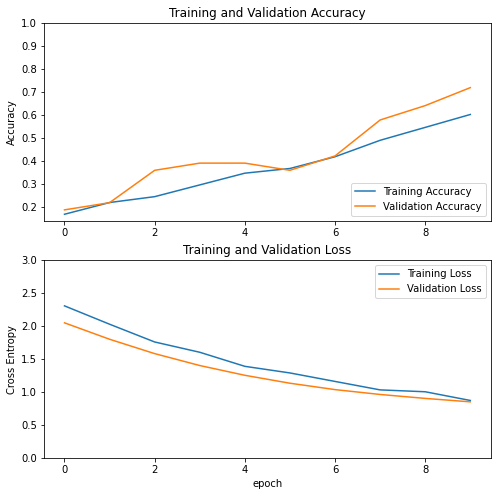

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

FINE TUNING

Rendiamo addestrabile una gran parte della rete ed effettuiamo quindi il fine-tuning.

In [ ]:
base_model.trainable = True

In [ ]:
# Finetuning degli ultimi 100 layer
fine_tune_at = 100

# Il resto dei layer non vengono addestrati
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy',f1_m,precision_m,recall_m])

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_b,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data = val_b)

Epoch 10/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 6s 249ms/step - loss: 0.4413 - accuracy: 0.7296 - f1_m: 0.7734 - precision_m: 0.8346 - recall_m: 0.7277 - val_loss: 0.3191 - val_accuracy: 0.8438 - val_f1_m: 0.8502 - val_precision_m: 0.8569 - val_recall_m: 0.8438
Epoch 11/30
7/7 [==============================] - 1s 94ms/step - loss: 0.3068 - accuracy: 0.8571 - f1_m: 0.8817 - precision_m: 0.8934 - recall_m: 0.8705 - val_loss: 0.2224 - val_accuracy: 0.8594 - val_f1_m: 0.8666 - val_precision_m: 0.8740 - val_recall_m: 0.8594
Epoch 12/30
7/7 [==============================] - 1s 94ms/step - loss: 0.2184 - accuracy: 0.9082 - f1_m: 0.9165 - precision_m: 0.9273 - recall_m: 0.9062 - val_loss: 0.1676 - val_accuracy: 0.9062 - val_f1_m: 0.9062 - val_precision_m: 0.9062 - val_recall_m: 0.9062
Epoch 13/30
7/7 [==============================] - 1s 92ms/step - loss: 0.1643 - accuracy: 0.9133 - f1_m: 0.9237 - precision_m: 0.9279 - recall_m: 0.9196 - val_loss: 0.1352 - val_accuracy: 0.9062 - val_f1_m: 0.9062 - va

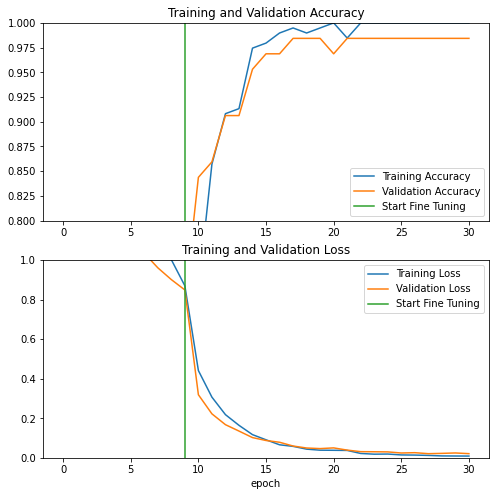

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Visualizziamo in un plot il training nel complesso: la linea verde indica dove è iniziata la fase di fine tuning. Il modello in questione performa più o meno come la nostra rete addestrata da zero.

In [ ]:
model.evaluate(test_b, batch_size=16)

3/3 [==============================] - 1s 241ms/step - loss: 0.0359 - accuracy: 0.9714 - f1_m: 0.9792 - precision_m: 0.9792 - recall_m: 0.9792


[0.03586965799331665,
 0.9714285731315613,
 0.9791666865348816,
 0.9791666865348816,
 0.9791666865348816]